In [70]:
import networkx as nx
import pandas as pd
import itertools as it
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
from thefuzz import fuzz
mpl.rcParams['pdf.fonttype'] = 42

def get_unambiguous_column_names(column_names):
    series = pd.Series(column_names)
    series[series.duplicated(keep = 'first')] = series[series.duplicated(keep = 'first')].apply(
        lambda x: x + '.1'
    )
    return series.to_list()

def parse_metabolomics_results(filename, delimiter = ',', quotechar = '"'):
    with open(filename) as csvfile:
        data = []
        entryid = None
        csvreader = csv.reader(
            csvfile,
            delimiter = delimiter,
            quotechar = quotechar
        )
        
        # get column names and make them unambiguous
        names = []
        for i in range(2):
            names = csvreader.__next__()
        
        names = get_unambiguous_column_names(names)
        
        add_names = [
                'Name2', 
                'Molecular Weight', 
                'RT [min]2', 
                'DeltaMass [ppm]', 
                'DBID', 
                'Reference List Name', 
                'mzLogic Score', 
                'ChemSpider ID', 
                'KEGG', 'HMDB', 
                'Mass List Search Results ID'
        ]
        add_names_set = set([k if not k in {'Name2', 'RT [min]2'} else k[:-1] for k in add_names]) # faster check
        series = None
        tmp_names = []
        add_rows = []
        
        def insert_addrow_into_series(series, names, values, add_names_set):
            series = series.copy()
            for k, v in zip(names, values):
                if k in add_names_set:
                    k = k + '2' if k in {'Name', 'RT [min]'} else k
                    series[k] = v if v else None

                elif k == 'KEGG ID':
                    series['KEGG'] = v if v else None
            
            return series
            
        for line in csvreader:
            if line[0]:
                if add_rows:
                    exact_match = False
                    partial_match = False
                    for row in add_rows:
                        if row[0] == series.Name:
                            data.append(
                                insert_addrow_into_series(
                                    series,
                                    tmp_names,
                                    row,
                                    add_names_set
                                )
                            )
                            exact_match = True
                            break
                    
                    if not exact_match:
                        for row in add_rows:
                            if fuzz.partial_ratio(row[0].lower(), series.Name.lower()) > 95:
                                data.append(
                                    insert_addrow_into_series(
                                        series,
                                        tmp_names,
                                        row,
                                        add_names_set
                                    )
                                )
                                partial_match = True
                                break
                    
                    if not partial_match:
                        data.append(series.copy())
                
                elif isinstance(series, pd.Series):
                    data.append(series.copy())
                    
                entryid = line[0]
                add_rows = []
                series = pd.Series(
                    {k: v for k, v in zip(names, line)}
                )
                
            elif line[1] == 'Name':
                tmp_names = [name for name in line if name]
            
            else:
                add_rows.append(line[1: 1 + len(tmp_names)])
    
    return pd.DataFrame(data, columns = names + add_names)

def clean_dataframe(df):
    no_kegg_rows = df.KEGG.isna()
    no_kegg = df.loc[no_kegg_rows, :].copy()
    kegg = df.loc[~no_kegg_rows, :].copy()
    for df in [kegg, no_kegg]:
        df.drop_duplicates(
            subset = ['ID', 'KEGG'],
            inplace = True
        )
    
    no_kegg = no_kegg.loc[~no_kegg.ID.isin(kegg.ID), :]
    return kegg, no_kegg

from scipy import integrate
def disparity_filter(G, alpha, weight = 'weight'):
    '''
    Implementation of disparity filter accroding to https://doi.org/10.1515%2Fjib-2021-0030
    basically a port of https://github.com/alessandrobessi/disparityfilter
    '''
    
    G_f = nx.Graph()
    attrs = {}
    for u, attr_dict in G.nodes(data = True):
        attrs[u] = attr_dict
        k = len(G[u])
        sum_w = sum(e[weight] for e in G[u].values())
        for v, d in G[u].items():
            # log prevents overflow warning in case of high exponents
            alpha_ij = np.log((1 - d[weight]/sum_w)) * (k - 1)
            if alpha_ij < np.log(alpha):
                G_f.add_edge(*sorted([u, v]), alpha = alpha_ij, **d)
                
    nx.set_node_attributes(
        G_f,
        attrs
    )
    
    return G_f

def disparity_filter_salvo(G, alpha, weight = 'weight'):
    '''
    Implementation of disparity filter as originally described in https://doi.org/10.1073/pnas.0808904106
    Code generously provided by Salvo D. Lombardo
    '''
    
    B = nx.Graph()
    for u in G:
        k = len(G[u])
        if k > 1:
            sum_w = sum(np.absolute(G[u][v][weight]) for v in G[u])
            for v in G[u]:
                w = G[u][v][weight]
                p_ij = float(np.absolute(w))/sum_w
                alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                if alpha_ij < alpha:
                    B.add_edge(u, v, weight = w, alpha=float('%.4f' % alpha_ij))
                    
    return B

In [2]:
hilic = parse_metabolomics_results('../raw/Results_Untargeted_Metabolomics_E14-P40_LK_Nova_results_HILIC.csv')
hilic, no_kegg_hilic = clean_dataframe(hilic)
rp = parse_metabolomics_results('../raw/Results_Untargeted_Metabolomics_E14-P40_LK_Nova_results_RP.csv')
rp, no_kegg_rp = clean_dataframe(rp)

In [3]:
# combine hilic and rp in two different ways
def get_clean_coarse_group(x):
    x = x.split('/')[0].strip().lower()
    if x.startswith('bio'):
        x = 'bioenergetic process'
        
    elif x.startswith('nucleoside'):
        x = 'nucleoside metabolism'
    
    elif x.startswith('glycolysis'):
        x = 'glycolysis'
    
    elif x.startswith('lipid'):
        x = 'lipid metablism'
    
    elif x.startswith('purine'):
        x = 'nucleoside metabolism'
        
    elif x.startswith('aa'):
        x = 'aa metabolism'
        
    else:
        x = 'other'
        
    return x

basedata = {}
for key in ['RP', 'HILIC']:
    base = pd.read_csv(
        f'../raw/untargeted_Metabo_Results_LKnaus_annotated_DM_clean_annot_{key}.csv',
        header = 1
    ).loc[:, ['ID', 'Name Metabolite ', 'Group ']]
    base.columns = ['ID', 'metabolitename', 'metabolitegroupfine']
    base['metabolitegroupcoarse'] = base.metabolitegroupfine.apply(
        get_clean_coarse_group
    )

    frames = []
    for df in [hilic, no_kegg_hilic, rp, no_kegg_rp]:
        frames.append(
            base.merge(
                df,
                on = 'ID',
                how = 'inner'
            )
        )
    
    df = pd.concat(frames).reset_index(drop = True)
    df.index = df.ID.to_list()
    basedata[key] = df

In [4]:
basedata['HILIC']

,ID,metabolitename,metabolitegroupfine,metabolitegroupcoarse,Name,Calc. MW,RT [min],"(P40, KO) / (P40, WT)","(P2, KO) / (P2, WT)","(E14_5, KO) / (E14_5, WT)",...,Molecular Weight,RT [min]2,DeltaMass [ppm],DBID,Reference List Name,mzLogic Score,ChemSpider ID,KEGG,HMDB,Mass List Search Results ID
A002_HILIC,A002_HILIC,L-(+)-Alanine,AA Metabolism / Alanine,aa metabolism,L-(+)-Alanine,89.0477,14.83,0.0,-0.1,0.0,...,89.0477,14.80,0.34,A072,iHILIC_neg_2020,74.9275,5735,C00041,HMDB0000161,57
A054_HILIC,A054_HILIC,L-(+)-Arginine,AA metabolism / Arginine,aa metabolism,L-(+)-Arginine,174.1118,25.41,-0.1,0.6,0.3,...,174.1117,25.52,0.64,E3,iHILIC_pos_2020,92.7285,6082,C00062,HMDB0000517,285
A062_HILIC,A062_HILIC,"NG,NG-dimethylarginine",AA metabolism / Arginine,aa metabolism,"NG,NG-dimethylarginine",202.1431,22.44,0.4,0.8,0.2,...,202.1430,22.61,0.54,A105,iHILIC_pos_2020,54.5226,110375,C03626,HMDB0001539,437
B122_HILIC,B122_HILIC,Creatine,AA metabolism / Arginine / Glycine,aa metabolism,Creatine,131.0695,14.89,0.0,0.0,-0.1,...,131.0695,NaN,0.10,NaN,NaN,NaN,NaN,C00300,NaN,NaN
A012_HILIC,A012_HILIC,L-Creatinine,AA metabolism / Arginine / Glycine,aa metabolism,L-Creatinine,113.0590,7.62,-0.1,-0.1,-0.3,...,113.0589,7.61,0.76,E25,iHILIC_pos_2020,71.8107,568,C00791,HMDB0000562,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C166_RP,C166_RP,2-arachidonoyl-sn-glycero-3-phosphocholine,Lipid metabolism / Phospholipid synthesis,lipid metablism,2-arachidonoyl-sn-glycero-3-phosphocholine,543.3329,28.56,0.3,0.5,-0.2,...,543.3325,NaN,0.69,NaN,NaN,18.2198109,NaN,NaN,NaN,NaN
C164_RP,C164_RP,2-arachidonyl-sn-glycero-3-phosphoethanolamine,Lipid metabolism / Phospholipid synthesis,lipid metablism,2-arachidonyl-sn-glycero-3-phosphoethanolamine,501.2858,28.35,0.6,0.2,0.4,...,501.2855,NaN,0.47,NaN,NaN,55.38292991,NaN,NaN,NaN,NaN
C161_RP,C161_RP,L-alpha-lysophosphatidylcholine,Lipid metabolism / Phospholipid synthesis,lipid metablism,L-alpha-lysophosphatidylcholine,467.3015,27.41,0.4,0.1,-0.2,...,467.3012,NaN,0.56,NaN,NaN,26.82693678,NaN,NaN,NaN,NaN
C116_RP,C116_RP,Phosphoryethanolamine,Lipid metabolism / Phospholipid synthesis,lipid metablism,Phosphoryethanolamine,141.0192,3.73,0.1,-0.2,-0.2,...,141.0191,NaN,0.74,NaN,NaN,None,NaN,NaN,NaN,NaN


In [60]:
#from statsmodels.stats.multitest import fdrcorrection
import numpy as np
data = basedata['HILIC']
networks = {}
gtdatas = {}
corr_mats = {}
genotype = 'WT'
def make_node(row):
    node = (
        row['ID'],
        {
            'name': row['metabolitename'],
            'group': row['metabolitegroupcoarse']
        }
    )
    return node

for timepoint in ['E14_5', 'P2', 'P40']:
    G = nx.Graph()
    G.add_nodes_from(
        [make_node(row) for i, row in data.iterrows()]
    )
    
    gtdata = data.loc[
        :, 
        data.columns[
            data.columns.str.match('S[0-9]{2}_' + timepoint + '_' + genotype + '[0-9]')
        ]
    ].astype(float)
    corr_mat = np.zeros(
        (len(data), len(data))
    )
    gtdatas[timepoint] = gtdata
    edges = []
    pvalues = []
    for (i, m1), (j, m2) in it.combinations(
        enumerate(gtdata.index), 2
    ):
        r, p = pearsonr(
            gtdata.loc[m1, :], gtdata.loc[m2, :]
        )
        
        corr_mat[i, j] = corr_mat[j, i] = r
        edges.append(
            (m1, m2, {'weight': r, 'absweight': abs(r)})
        )
        pvalues.append(p)
    
    corr_mats[timepoint] = corr_mat
    # reject, adjpval = fdrcorrection(
    #     pvalues,
    #     alpha = 0.25
    # )
    G.add_edges_from(
        #[e for e, p in zip(edges, pvalues) if p <= 0.05]
        [e for e in edges if not e[2]['absweight'] == 0]
    )
    networks[timepoint] = G

In [80]:
G1 = disparity_filter(G, 0.15, 'absweight')

/users/daniel.malzl/.conda/envs/carto/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/daniel.malzl/.conda/envs/carto/lib/python3.10/site-packages/cartoGRAPHs/cartoGRAPHs.py:181: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
/users/daniel.malzl/.conda/envs/carto/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/users/daniel.malzl/.conda/envs/carto/lib/python3.10/site-packages/cartoGRAPHs/cartoGRAPHs.py:181: FutureWarning: adjacency_matrix will return a scipy.s

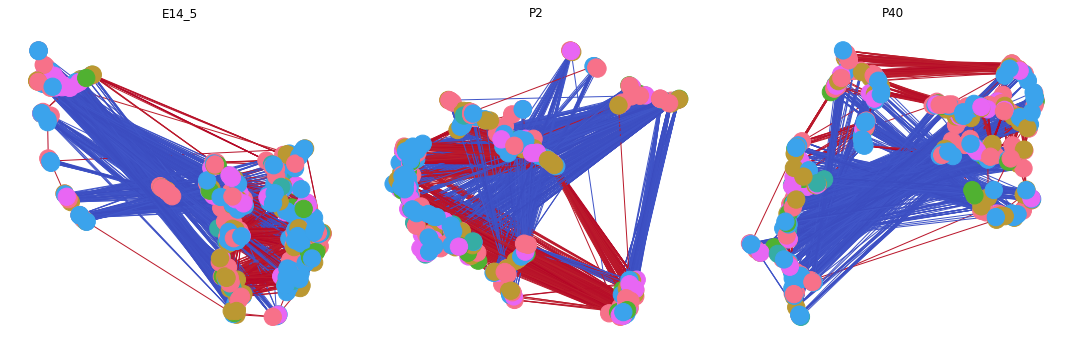

In [6]:
from cartoGRAPHs import *
import seaborn as sns
fig, axs = plt.subplots(1, 3)

palette = sns.color_palette('husl', data.metabolitegroupcoarse.nunique())
node_group_colors = {
    group: palette[i] for i, group in enumerate(data.metabolitegroupcoarse.unique())
}
cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
for (timepoint, G), ax in zip(networks.items(), axs):
    nx.draw(
        G, 
        ax = ax, 
        node_color = [
            node_group_colors[group] for n, group in G.nodes.data('group')
        ],
        edge_color = [
            cmap(norm(weight)) for n1, n2, weight in G.edges.data('weight')
        ],
        pos = generate_layout(
            G, 
            dim = 2, 
            layoutmethod = 'global',
            dimred_method='umap'
        )
    )
    ax.set_title(timepoint)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.tight_layout()

In [7]:
import umap
def make_umap_network(G):
    W = rnd_walk_matrix2(
        nx.adjacency_matrix(G),
        0.9,
        1.0,
        G.number_of_nodes()
    )
    umapper = umap.UMAP(
        n_neighbors = 8,
        spread = 1.0,
        min_dist = 0.0,
        n_components = 2,
        metric = 'cosine',
        random_state = 42,
        learning_rate = 1,
        n_epochs = None
    )
    umapper.fit(W.T)
    adj_mat = umapper.graph_.toarray()
    
    umap_g = nx.Graph()
    umap_g.add_nodes_from(
        [(n, {'group': g}) for n, g in G.nodes.data('group')]
    )
    edges = []
    node_list = list(G.nodes)
    for i in range(adj_mat.shape[0]):
        for j in range(i, adj_mat.shape[1]):
            weight = adj_mat[i, j]
            if weight:
                edges.append(
                    (
                        node_list[i], 
                        node_list[j], 
                        {'weight': weight}
                    )
                )
            
            else:
                continue
    umap_g.add_edges_from(
        edges
    )
    return umap_g

0 20224
1 96519
2 70977


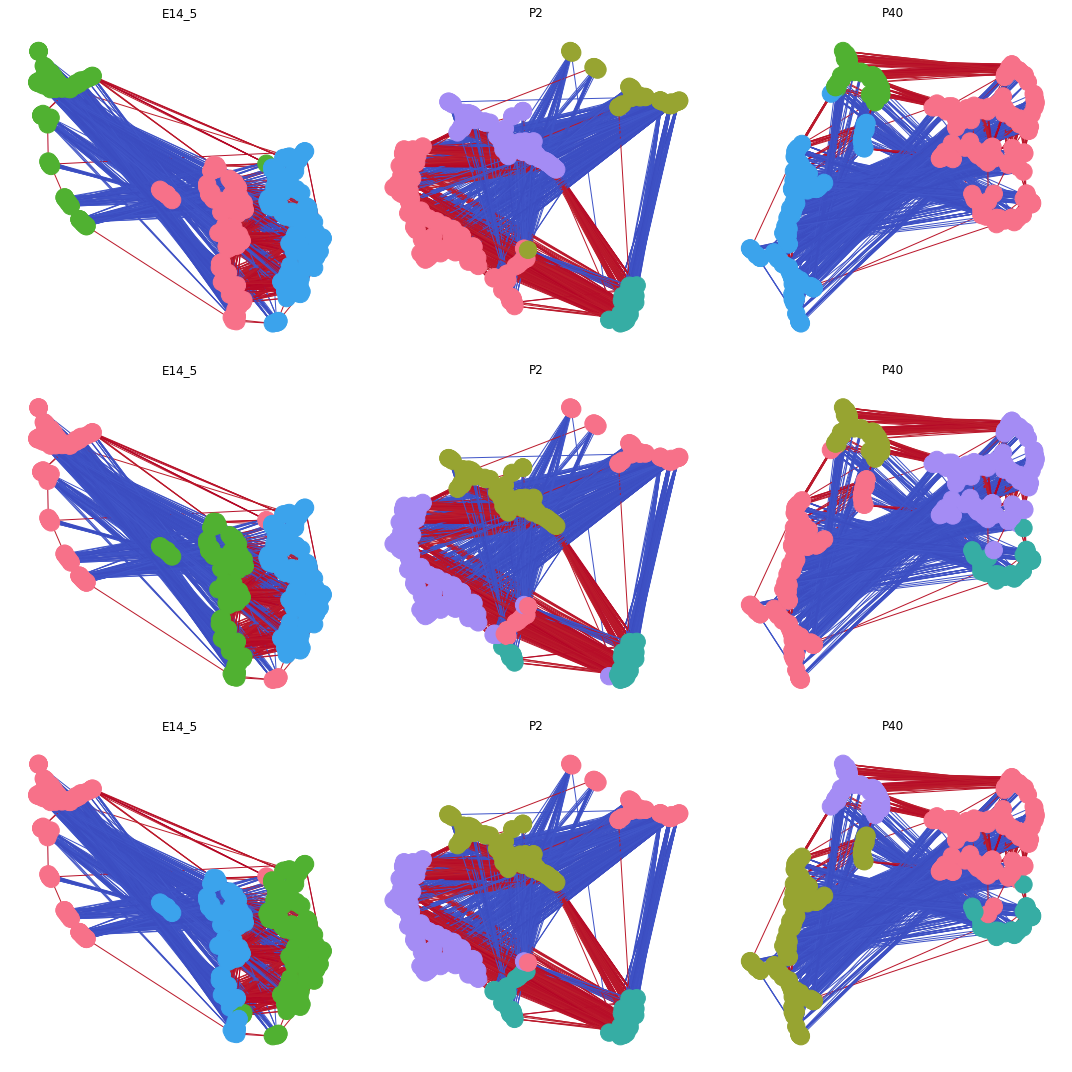

In [8]:
import networkx.algorithms.community as nx_comm
import warnings
nice_seeds = [20224, 96519, 70977]
cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
#ntries = 25
fig, ax_mat = plt.subplots(len(nice_seeds), 3)
for i in range(len(nice_seeds)):
    seed = nice_seeds[i]
    print(i, seed)
    axs = ax_mat[i, :]
    for (timepoint, G), ax in zip(networks.items(), axs):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            umap_g = make_umap_network(G)
            
        communities = nx_comm.louvain_communities(
            umap_g, 
            weight = 'weight', 
            resolution = 0.16,
            seed = seed
        )
        community_dict = {}
        for i, community in enumerate(communities):
            for node in community:
                G.nodes[node]['community'] = i
                community_dict[node] = i

        palette = sns.color_palette('husl', len(communities))
        node_colors = [palette[comm[1]] for comm in G.nodes.data('community')]
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            pos = generate_layout(
                G, 
                dim = 2, 
                layoutmethod = 'global',
                dimred_method='umap'
            )
        nx.draw(
            G, 
            ax = ax, 
            node_color = node_colors,
            edge_color = [
                cmap(norm(weight)) for n1, n2, weight in G.edges.data('weight')
            ],
            pos = pos
        )
        ax.set_title(timepoint)
    
fig.set_figwidth(15)
fig.set_figheight(5 * len(nice_seeds))
fig.tight_layout()

In [9]:
from collections import defaultdict
def get_communities(G, data_kwd):
    communities = defaultdict(list)
    for node, community in G.nodes.data(data_kwd):
        communities[community].append(node)
    
    return communities

communities = {
    timepoint: get_communities(G, 'community') for timepoint, G in networks.items()
}

In [10]:
kegg_communities = {}
for timepoint, communities_dict in communities.items():
    kegg_communities[timepoint] = {}
    for community, community_list in communities_dict.items():
        kegg_communities[timepoint][community] = []
        for metabolite in community_list:
            kegg = data.loc[metabolite, 'KEGG']
            if isinstance(kegg, str):
                kegg_communities[timepoint][community].append(kegg)

In [11]:
# the following cells are a simple implementation of a pathway enrichment analysis
# based on differential abundance of compounds using Fisher's exact test
def compute_overlaps(diff_compounds, pathways, metabolites = None):
    '''
    computes overlaps between differentially regulated compounds and 
    each set of pathway compounds. Pathway compounds are limited to
    the set of compounds given by metabolites (i.e. adjustment to background
    aka only quantified metabolites are considered)
    '''
    diff_compounds = set(diff_compounds)
    overlaps = []
    for key, pathway in pathways.items():
        if 'COMPOUND' in pathway:
            pathway_metabolites = set(pathway['COMPOUND'].keys())
            if metabolites:
                pathway_metabolites = pathway_metabolites.intersection(
                    set(metabolites)
                )
            overlaps.append(
                [
                    key, 
                    pathway['NAME'][0],
                    len(
                        diff_compounds.intersection(
                            pathway_metabolites
                        )
                    ),
                    len(pathway_metabolites),
                    list(pathway_metabolites)
                ]
            )
    
    return pd.DataFrame(overlaps, columns = ['mapid', 'name', 'ncommon', 'ncompounds', 'compounds'])

# pvalue computation based on hypergeometric distribution
from scipy.stats import hypergeom
import numpy as np
def pvalue(k, M, n, N):
    """
    computes the probability to find k or more overlapping genes between two gene sets
    of n and N genes, where n is the number of genes in the gene set to which we overlap
    (i.e. number of genes in a pathway or number of differentially expressed genes in
    another patient) and N is the number of genes in the gene set which we are interested
    in (i.e. number of differentially expressed genes) which are drawn from M total genes
    (i.e. number of genes considered during differential expression analysis). This is also
    known as computing the pvalue for fisher's exact test.
    See http://www.pathwaycommons.org/guide/primers/statistics/fishers_exact_test/ for
    more information on how this is computed
    :param k:   number of common genes between two gene sets
    :param M:   total number of genes considered during DEA
    :param n:   number of genes in gene set with which we overlap
    :param N:   number of differentially expressed genes
    :return:    probability to find k or more common genes between the two gene sets
    """
    # k - 1 because we are computing P(x >= k) which includes k
    pval = hypergeom.sf(
        k - 1, M, n, N
    )
    return pval

In [13]:
pseudo_pathways = {}
for name, groupdf in basedata['HILIC'].groupby('metabolitegroupcoarse'):
    pathway = {
        'NAME': [name, ''],
        'COMPOUND': {
            row['ID'].upper(): row['Name'] for i, row in groupdf.iterrows()
        }
    }

    pseudo_pathways[name] = pathway

In [14]:
import pickle
def select_maps(pathwaydict, class_contains):
    selection = {}
    for k, v in pathwaydict.items():
        if 'CLASS' in v and any([pattern in v['CLASS'][0].lower() for pattern in class_contains]):
            selection[k] = v
            
    return selection

with open('../raw/kegg_pathway_maps.pickle', 'rb') as handle:
    pathwaymaps = pickle.load(handle)
    
selected_pathways = select_maps(
    pathwaymaps,
    ['metabolism', 'information processing']
)

In [17]:
timepoint = 'E14_5'
for key, communities_dict in zip(['all', 'kegg'], [communities, kegg_communities]):
    nbackground = 0
    for community in communities_dict[timepoint].values():
        nbackground += len(community)
    
    print(key, nbackground)

all 346
kegg 178


In [18]:
kegg_metabolites = set()
for community in kegg_communities[timepoint].values():
    kegg_metabolites.update(
        set(community)
    )
kegg_metabolites = list(kegg_metabolites)

In [22]:
from statsmodels.stats.multitest import fdrcorrection
results = {}
for key, timepoint_dict, nbackground, pathways, restrict_metabolites in zip(
    ['all', 'kegg'], 
    [communities, kegg_communities], 
    [346, 178],
    [pseudo_pathways, selected_pathways],
    [None, kegg_metabolites]
):
    results[key] = {}
    for timepoint, communities_dict in timepoint_dict.items():
        frames = []
        for c, community in communities_dict.items():
            enriched = compute_overlaps(
                community,
                pathways,
                restrict_metabolites
            )
            enriched['pvalue'] = enriched.apply(
                lambda x: pvalue(
                    x.ncommon, 
                    nbackground, 
                    x.ncompounds, 
                    len(community)
                ),
                axis = 1
            )
            for values, col in zip(
                fdrcorrection(enriched.pvalue, method = 'indep'),
                ['reject', 'padj']
            ):
                enriched[col] = values
                
            enriched.sort_values(
                by = 'pvalue',
                inplace = True
            )
            enriched['community'] = c
            frames.append(enriched)
        
        df = pd.concat(frames)
        df.reset_index(
            drop = True, 
            inplace = True
        )
        results[key][timepoint] = df

In [29]:
results['kegg']['P40']

,mapid,name,ncommon,ncompounds,compounds,pvalue,reject,padj,community
0,mmu00590,Arachidonic acid metabolism - Mus musculus (mo...,2,2,"[C00219, C00696]",0.012061,False,0.828814,2
1,mmu00270,Cysteine and methionine metabolism - Mus muscu...,5,15,"[C00019, C00979, C00049, C00065, C00073, C0005...",0.015492,False,0.828814,2
2,mmu00250,"Alanine, aspartate and glutamate metabolism - ...",4,12,"[C01042, C00049, C12270, C00064, C00025, C0004...",0.032101,False,1.000000,2
3,mmu00760,Nicotinate and nicotinamide metabolism - Mus m...,3,8,"[C00111, C00049, C00006, C00042, C00334, C0015...",0.047358,False,1.000000,2
4,mmu00730,Thiamine metabolism - Mus musculus (mouse),2,4,"[C00022, C00082, C00378, C00003]",0.062858,False,1.000000,2
...,...,...,...,...,...,...,...,...,...
423,mmu00770,Pantothenate and CoA biosynthesis - Mus muscul...,0,4,"[C00022, C00106, C00049, C00010]",1.000000,False,1.000000,0
424,mmu00780,Biotin metabolism - Mus musculus (mouse),0,1,[C00047],1.000000,False,1.000000,0
425,mmu00785,Lipoic acid metabolism - Mus musculus (mouse),0,0,[],1.000000,False,1.000000,0
426,mmu00532,Glycosaminoglycan biosynthesis - chondroitin s...,0,0,[],1.000000,False,1.000000,0


# temporal multilayer graph with infomap

In [21]:
# write multilayer network in multilayer format
from infomap import Infomap
from io import StringIO
data = basedata['HILIC']
gtdatas = {}
pjks = [StringIO(), StringIO(), StringIO()]
for pjk in pjks:
    pjk.write('# A multilayer network using explicit format\n')
    pjk.write('*Vertices {}\n'.format(len(data)))
    pjk.write('# node_id name\n')
    for node_id, node_name in enumerate(data.ID):
        node_id += 1
        pjk.write(f'{node_id} "{node_name}"\n')
    
    pjk.write('*Multilayer\n')
    pjk.write('# layer_id node_id layer_id node_id weight\n# intra\n')
    
for layer_id, timepoint in enumerate(['E14_5', 'P2', 'P40']):
    layer_id += 1
    gtdata = data.loc[
        :, 
        data.columns[
            data.columns.str.match('S[0-9]{2}_' + timepoint + '_WT[0-9]')
        ]
    ].astype(float)
    gtdatas[timepoint] = gtdata
    for (i, m1), (j, m2) in it.combinations(
        enumerate(data.ID), 2
    ):
        # start node_ids at 1 instead of 0
        i += 1
        j += 1
        r, p = pearsonr(
            gtdata.loc[m1, :], gtdata.loc[m2, :]
        )

        if p <= 0.05:
            pjks[2].write(f'{layer_id} {i} {layer_id} {j} {abs(r)}\n')
               
            if r < 0:
                pjks[1].write(f'{layer_id} {i} {layer_id} {j} {abs(r)}\n')
            
            else:
                pjks[0].write(f'{layer_id} {i} {layer_id} {j} {r}\n')
                
for pjk in pjks:
    pjk.write('#inter\n')
    
for (layer_id1, t1), (layer_id2, t2) in [
    ((1, 'E14_5'), (2, 'P2')), ((2, 'P2'), (3, 'P40'))
]:
    for (i, m1), (j, m2) in it.product(enumerate(data.ID), repeat = 2):
        r, p = pearsonr(
            gtdatas[t1].loc[m1, :], gtdatas[t2].loc[m2, :]
        )
        i += 1
        j += 1
        if p <= 0.05:
            pjks[2].write(f'{layer_id1} {i} {layer_id2} {j} {abs(r)}\n')
            if r < 0:
                pjks[1].write(f'{layer_id1} {i} {layer_id2} {j} {abs(r)}\n')
            
            else:
                pjks[0].write(f'{layer_id1} {i} {layer_id2} {j} {r}\n')

for buffer, suffix in zip(pjks, ['_pos', '_neg', '']):
    with open(f'../data/temporal_network{suffix}.multilayer.pjk', 'w') as pjkfile:
        pjkfile.write(buffer.getvalue())
        buffer.close()

In [19]:
data = basedata['HILIC']
data_cols = data.columns[data.columns.str.match('S[0-9]{2}_[EP][0-9][_0-9]+WT[0-9]')].to_list()
data_col_grouping = [c[4:-4] for c in data_cols] 
gm_data = data.loc[:, data_cols].astype(float)
gm_data = gm_data.T
gm_data = gm_data.groupby(data_col_grouping).mean().T
gm_data = gm_data.apply(
    lambda x: (x - x.min()) / (x.max() - x.min()),
    axis = 1
)
gm_data

,E14_5,P2,P40
A002_HILIC,1.000000,0.000000,0.342857
A054_HILIC,0.097852,0.000000,1.000000
A062_HILIC,1.000000,0.881657,0.000000
B122_HILIC,0.888889,0.000000,1.000000
A012_HILIC,0.813953,0.000000,1.000000
...,...,...,...
C166_RP,0.000000,0.015720,1.000000
C164_RP,0.639175,0.000000,1.000000
C161_RP,0.173893,1.000000,0.000000
C116_RP,0.859504,1.000000,0.000000


In [22]:
# write multilayer network in state format
from infomap import Infomap
from io import StringIO
import numpy as np
data = basedata['HILIC']
pjks = [StringIO(), StringIO(), StringIO()]
for pjk in pjks:
    pjk.write('# A network in state format\n')
    pjk.write('*Vertices {}\n'.format(len(data)))
    pjk.write('# node_id name\n')
    for node_id, node_name in enumerate(data.ID):
        node_id += 1
        pjk.write(f'{node_id} "{node_name}"\n')
    
    pjk.write('*States\n')
    pjk.write('# state_id node_id as defined above "node_name" weight\n')

    
state_id = 1
state_id_map = {}
for layer_id, timepoint in enumerate(['E14_5', 'P2', 'P40']):
    layer_id += 1
    weights = gm_data.loc[:, timepoint].values.copy()
    
    # allow for a very minimal node weight
    weights[weights == 0] = 0.01
    for node_id, (node_name, weight) in enumerate(zip(data.ID, weights)):
        node_id += 1
        state_id_map[(node_id, layer_id)] = state_id
        node_name = node_name + '_' + timepoint
        
        for pjk in pjks:
            pjk.write(f'{state_id} {node_id} "{node_name}" {weight}\n')
            
        state_id += 1
            

for pjk in pjks:
    pjk.write('*Links\n')
    pjk.write('# state_id state_id weight\n')
    # pjk.write('*Multilayer\n')
    # pjk.write('# layer_id node_id layer_id node_id weight\n# intra\n')
    
gtdatas = {}
for layer_id, timepoint in enumerate(['E14_5', 'P2', 'P40']):
    layer_id += 1
    gtdata = data.loc[
        :, 
        data.columns[
            data.columns.str.match('S[0-9]{2}_' + timepoint + '_WT[0-9]')
        ]
    ].astype(float)
    gtdatas[timepoint] = gtdata
    for (i, m1), (j, m2) in it.combinations(
        enumerate(data.ID), 2
    ):
        # start node_ids at 1 instead of 0
        i += 1
        j += 1
        r, p = pearsonr(
            gtdata.loc[m1, :], gtdata.loc[m2, :]
        )
        
        state_id1 = state_id_map[(i, layer_id)]
        state_id2 = state_id_map[(j, layer_id)]
        
        if p <= 0.05:
            link_string = f'{state_id1} {state_id2}' + ' {}\n'
            # link_string = f'{layer_id} {state_id1} {layer_id} {state_id2}' + ' {}\n'
            pjks[2].write(link_string.format(abs(r)))
               
            if r < 0:
                pjks[1].write(link_string.format(abs(r)))
            
            else:
                pjks[0].write(link_string.format(r))

for (layer_id1, t1), (layer_id2, t2) in [
    ((1, 'E14_5'), (2, 'P2')), ((2, 'P2'), (3, 'P40'))
]:
    for (i, m1), (j, m2) in it.product(enumerate(data.ID), repeat = 2):
        r, p = pearsonr(
            gtdatas[t1].loc[m1, :], gtdatas[t2].loc[m2, :]
        )
        i += 1
        j += 1
        state_id1 = state_id_map[(i, layer_id)]
        state_id2 = state_id_map[(i, layer_id)]
        
        if p <= 0.05:
            link_string = f'{state_id1} {state_id2}' + ' {}\n'
            # link_string = f'{layer_id1} {state_id1} {layer_id2} {state_id2}' + ' {}\n'
            pjks[2].write(link_string.format(abs(r)))
               
            if r < 0:
                pjks[1].write(link_string.format(abs(r)))
            
            else:
                pjks[0].write(link_string.format(r))
                
for buffer, suffix in zip(pjks, ['_pos', '_neg', '']):
    with open(f'../data/temporal_network{suffix}.states.pjk', 'w') as pjkfile:
        pjkfile.write(buffer.getvalue())
        buffer.close()

In [36]:
from infomap import Infomap
from collections import defaultdict

def parse_state_node(line):
    if line.startswith('#'):
        return None
    
    else:
        return line.rstrip().split()
    
def parse_pjk_file(pjkfile):
    state_layer_map = dict()
    layer_id_map = {
        t: i + 1 for i, t in enumerate(['E14_5', 'P2', 'P40'])
    }
    with open(pjkfile, 'r') as pjk:
        parse_states = False
        for line in pjk:
            if line.startswith('*States'):
                parse_states = True
                continue
                
            if line.startswith('*Links'):
                break
            
            if parse_states:
                state_node = parse_state_node(line)
                if not state_node:
                    continue
                
                else:
                    state_id, physical_id, name, weight = state_node
                    name = name.strip('"')
                    state_layer_map[int(state_id)] = layer_id_map[name.split('_', maxsplit = 2)[-1]]
    
    return state_layer_map
    
def run_infomap(pjkfile, arguments):
    im = Infomap(arguments)
    im.read_file(pjkfile)
    
    # run infomap once to get access to all the attributes
    im.run(silent = True)
    
    # this is a workaround to also add layer information to the state network
    # might also be solved when building network directly via API
    state_id_to_layer_id_map = parse_pjk_file(pjkfile)
    for node in im.get_nodes(states = True):
        node.layerId = state_id_to_layer_id_map[node.stateId]
    
    im.run()
    return im

def get_state_id_map(im):
    nodes = dict()
    for node in im.nodes:
        nodes[node.stateId] = (node.layerId, node.node_id)
    
    return nodes

def get_module_id_map(im):
    return {node.stateId: node.module_id for node in im.nodes}

def nx_from_im(im):
    nodes = get_state_id_map(im)
    modules = get_module_id_map(im)
    names = im.get_names()
    G = nx.Graph()
    for state_id, (layer_id, physical_id) in nodes.items():
        G.add_node(
            state_id, 
            layer = layer_id, 
            name = names[physical_id],
            module = modules[state_id]
        )
    
    for state_id1, state_id2, weight in im.links:
        G.add_edge(
            state_id1,
            state_id2,
            weight = weight
        )
    
    return G

In [10]:
def _process_params(G, center, dim):
    # Some boilerplate code.
    import numpy as np

    if not isinstance(G, nx.Graph):
        empty_graph = nx.Graph()
        empty_graph.add_nodes_from(G)
        G = empty_graph

    if center is None:
        center = np.zeros(dim)
    else:
        center = np.asarray(center)

    if len(center) != dim:
        msg = "length of center coordinates must match dimension of layout"
        raise ValueError(msg)

    return G, center


def multipartite_layout(G, subset_key="subset", align="vertical", scale=1, center=None):
    """Position nodes in layers of straight lines.

    Parameters
    ----------
    G : NetworkX graph or list of nodes
        A position will be assigned to every node in G.

    subset_key : string (default='subset')
        Key of node data to be used as layer subset.

    align : string (default='vertical')
        The alignment of nodes. Vertical or horizontal.

    scale : number (default: 1)
        Scale factor for positions.

    center : array-like or None
        Coordinate pair around which to center the layout.

    Returns
    -------
    pos : dict
        A dictionary of positions keyed by node.

    Examples
    --------
    >>> G = nx.complete_multipartite_graph(28, 16, 10)
    >>> pos = nx.multipartite_layout(G)

    Notes
    -----
    This algorithm currently only works in two dimensions and does not
    try to minimize edge crossings.

    Network does not need to be a complete multipartite graph. As long as nodes
    have subset_key data, they will be placed in the corresponding layers.

    """
    import numpy as np

    if align not in ("vertical", "horizontal"):
        msg = "align must be either vertical or horizontal."
        raise ValueError(msg)

    G, center = _process_params(G, center=center, dim=2)
    if len(G) == 0:
        return {}

    layers = {}
    for v, data in G.nodes(data=True):
        try:
            layer = data[subset_key]
        except KeyError:
            msg = "all nodes must have subset_key (default='subset') as data"
            raise ValueError(msg)
        layers[layer] = [v] + layers.get(layer, [])

    # Sort by layer, if possible
    try:
        layers = sorted(layers.items())
    except TypeError:
        layers = list(layers.items())

    pos = None
    nodes = []
    width = len(layers)
    for i, (_, layer) in enumerate(layers):
        height = len(layer)
        xs = np.repeat(float(i * 5), height)
        xs += np.random.rand(height)
        ys = np.arange(0, height, dtype=float)
        offset = ((width - 1) / 2, (height - 1) / 2)
        layer_pos = np.column_stack([xs, ys]) - offset
        if pos is None:
            pos = layer_pos
        else:
            pos = np.concatenate([pos, layer_pos])
        nodes.extend(layer)
    #pos = rescale_layout(pos, scale=scale) + center
    if align == "horizontal":
        pos = pos[:, ::-1]  # swap x and y coords
    pos = dict(zip(nodes, pos))
    return pos

Parsing undirected network from file '../data/temporal_network.states.pjk'...
  Parsing vertices...
  -> 346 physical nodes added
  Parsing state nodes...
  -> 1038 state nodes added
  Parsing links...
  -> 13914 links
Done!
-------------------------------------
  -> 1038 state nodes
  -> 346 physical nodes
  -> 13914 links with total weight 25591.527632519
  Infomap v2.5.0 starts at 2022-06-23 09:46:48
  -> Input network: 
  -> No file output!
  -> Configuration: ftree
                    two-level
                    markov-time = 7.5
                    num-trials = 10
  OpenMP 201511 detected with 2 threads...
  -> Found higher order network input, using the Map Equation for higher order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1.000000000, sum link flow: 1.000000000
Build internal network with 1038 nodes and 13914 links...
Calculating one-level codelength... done!
 -> One-level codelength: 8.38

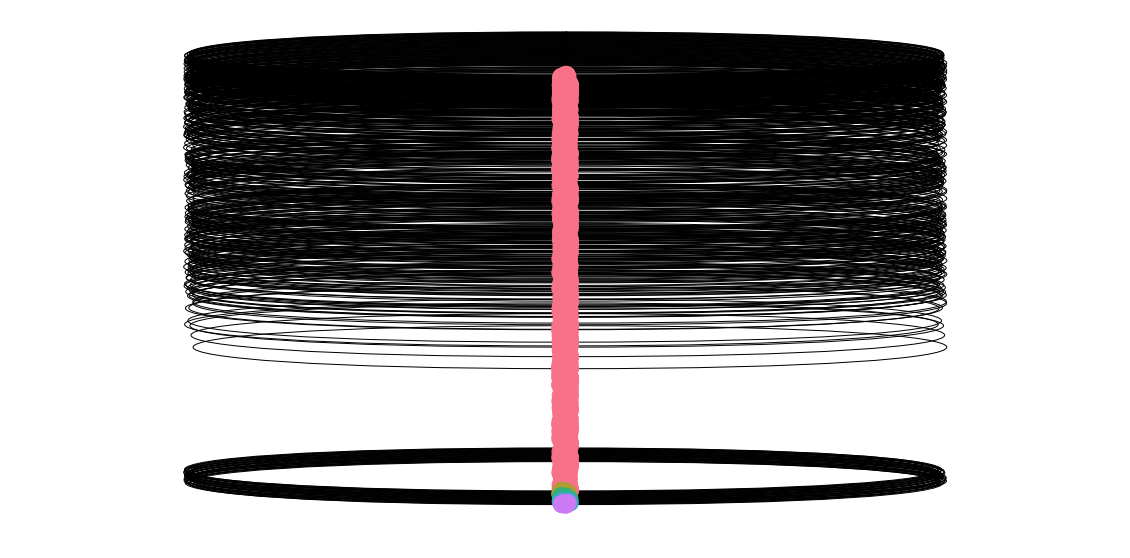

In [37]:
import seaborn as sns
import numpy as np
im = run_infomap(
    '../data/temporal_network.states.pjk',
    '-2 -N 10 --markov-time 7.5 --ftree --use-node-weights-as-flow'
)
G = nx_from_im(im)
palette = sns.color_palette('husl', im.num_top_modules)
fig, ax = plt.subplots()
pos = multipartite_layout(G, subset_key = 'layer', center = [1, 1])
nx.draw(
    G,
    node_color = [palette[module - 1] for n, module in G.nodes.data('module')],
    pos = pos,
    ax = ax
)
fig.set_figwidth(20)
fig.set_figheight(10)

Parsing undirected network from file '../data/temporal_network_neg.pjk'...
  Parsing vertices...
  -> 346 physical nodes added
  Parsing multilayer links...
  -> 11043 links in 3 layers
    -> 3693 intra-layer links
    -> 7350 inter-layer links
Done!
-------------------------------------
  -> 1036 state nodes
  -> 346 physical nodes
  -> 11043 links with total weight 10769.742192237
  Infomap v2.5.0 starts at 2022-06-22 16:20:35
  -> Input network: 
  -> No file output!
  -> Configuration: ftree
                    two-level
                    markov-time = 0.9
                    num-trials = 10
                    prefer-modular-solution
  OpenMP 201511 detected with 2 threads...
  -> Found higher order network input, using the Map Equation for higher order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1.000000000, sum link flow: 1.000000000
Build internal network with 1036 nodes and 11043 links...
C

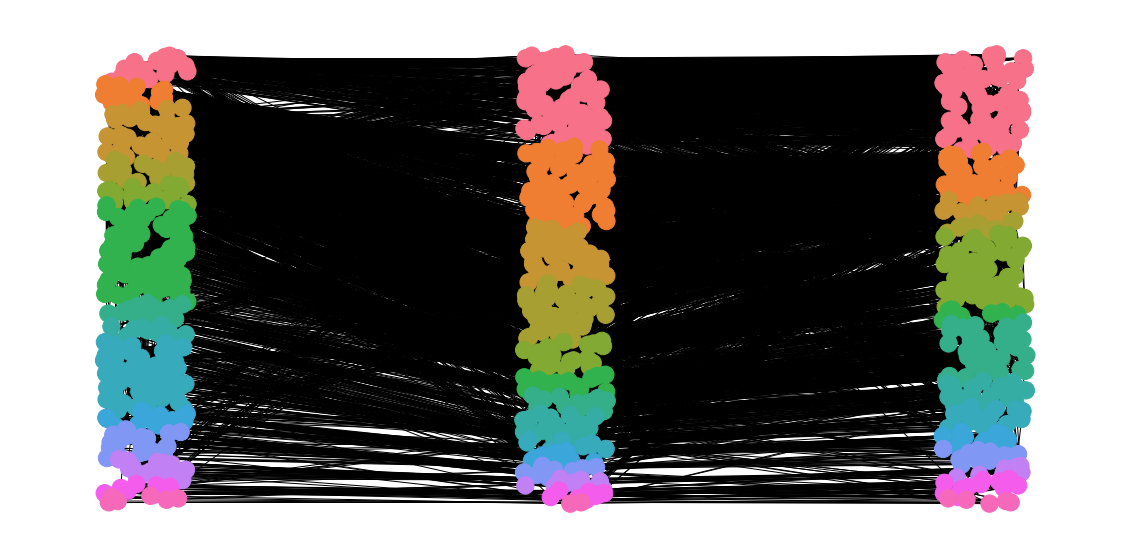

In [109]:
import seaborn as sns
import numpy as np
args = '-2 -N 10 --markov-time 0.9 --ftree'
im = run_infomap('../data/temporal_network_neg.pjk', args)
G = nx_from_im(im)
palette = sns.color_palette('husl', im.num_top_modules)
fig, ax = plt.subplots()
pos = multipartite_layout(G, subset_key = 'layer', center = [1, 1])
nx.draw(
    G,
    node_color = [palette[module - 1] for n, module in G.nodes.data('module')],
    pos = pos,
    ax = ax
)
fig.set_figwidth(20)
fig.set_figheight(10)

Parsing undirected network from file '../data/temporal_network_pos.pjk'...
  Parsing vertices...
  -> 346 physical nodes added
  Parsing multilayer links...
  -> 15197 links in 3 layers
    -> 9875 intra-layer links
    -> 5322 inter-layer links
Done!
-------------------------------------
  -> 1038 state nodes
  -> 346 physical nodes
  -> 15197 links with total weight 14821.785440281
  Infomap v2.5.0 starts at 2022-06-22 16:21:46
  -> Input network: 
  -> No file output!
  -> Configuration: ftree
                    two-level
                    markov-time = 1.25
                    num-trials = 10
                    prefer-modular-solution
  OpenMP 201511 detected with 2 threads...
  -> Found higher order network input, using the Map Equation for higher order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1.000000000, sum link flow: 1.000000000
Build internal network with 1038 nodes and 15197 links...


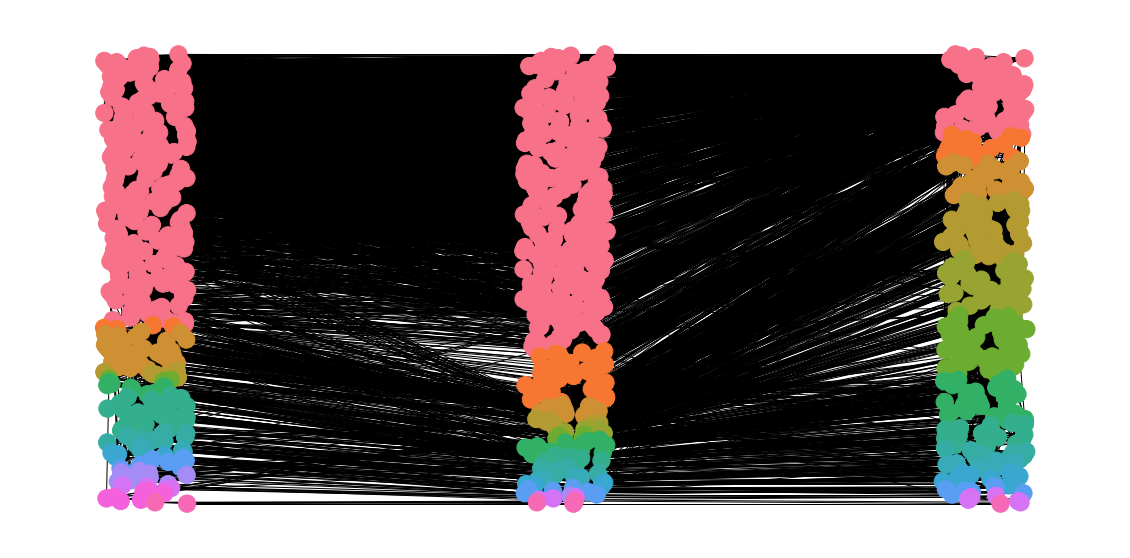

In [112]:
import seaborn as sns
args = '-2 -N 10 --markov-time 1.25 --ftree --prefer-modular-solution'
im = run_infomap('../data/temporal_network_pos.pjk', args)
G = nx_from_im(im)
palette = sns.color_palette('husl', im.num_top_modules)
fig, ax = plt.subplots()
pos = multipartite_layout(G, subset_key = 'layer')
nx.draw(
    G,
    node_color = [palette[module - 1] for n, module in G.nodes.data('module')],
    pos = pos,
    ax = ax
)
fig.set_figwidth(20)
fig.set_figheight(10)

# tryout edge filtering

In [113]:
import numpy as np
def effective_distance(n1, n2, data):
    return 1/abs(data['weight'])

def pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = it.tee(iterable)
    next(b, None)
    return zip(a, b)

def pairwise_shortest_paths(G):
    shortest_paths = {}
    for node, path_dict in nx.all_pairs_dijkstra_path(G, weight = effective_distance):
        path_dict.pop(node)
        shortest_paths[node] = [path for path in path_dict.values()]
        
    return shortest_paths
    
def _compute_saliency(shortest_paths, imap = None, n = None):
    if not imap:
        imap = {k: i for i, k in enumerate(shortest_paths.keys())}
    
    if not n:
        n = len(shortest_paths)
        
    spt = np.zeros((n, n))
    for paths in shortest_paths.values():
        already_seen = set()
        for path in paths:
            for edge in pairwise(path):
                if not edge in already_seen:
                    i1 = imap[edge[0]]
                    i2 = imap[edge[1]]
                    spt[i1, i2] += 1
                    spt[i2, i1] += 1
                    already_seen.add(edge)
    
    return spt/len(shortest_paths), imap

def compute_saliency(G):
    shortest_paths = pairwise_shortest_paths(G)
    S, imap = _compute_saliency(shortest_paths)
    for n1, n2 in G.edges:
        G.edges[n1, n2]['sij'] = S[imap[n1], imap[n2]]
    
    return G

0.8111753371868978


(array([1.1692e+04, 2.2430e+03, 7.2200e+02, 2.9900e+02, 1.4500e+02,
        6.3000e+01, 2.3000e+01, 9.0000e+00, 1.0000e+00, 0.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

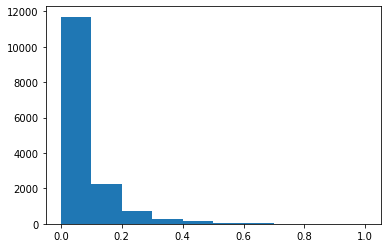

In [114]:
compute_saliency(G)
x = [e[2] for e in G.edges.data('sij')]
print(max(x))
plt.hist(
    x = [e[2] for e in G.edges.data('sij')],
    bins = 10,
    range = [0, 1]
)

0.8179190751445087
0.884393063583815
0.6676300578034682


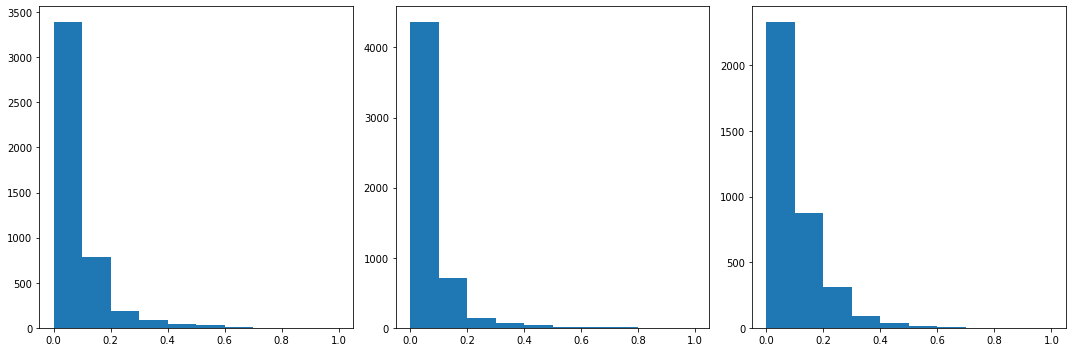

In [27]:
fig, axs = plt.subplots(1, 3)

for G, ax in zip(networks.values(), axs):
    compute_saliency(G)
    x = [e[2] for e in G.edges.data('sij')]
    print(max(x))
    ax.hist(
        x = [e[2] for e in G.edges.data('sij')],
        bins = 10,
        range = [0, 1]
    )

fig.set_figwidth(15)
fig.set_figheight(5)
fig.tight_layout()

In [ ]:
import numpy as np
from math import ceil
def min_pairwise_difference(weights):
    diffs = []
    for wi, wj in it.combinations(weights, 2):
        diffs.append(abs(wi - wj))
    
    return min(diffs)

def get_unique_weights(G):
    return np.unique([e[2] for e in G.edges.data('weight')])
    
def gloss_filter(G):
    unique_weights = get_unique_weights(G)
    dw = min_pairwise_difference(
        unique_weights
    )
    kmax = max([k for n, k in G.degree()])
    wmax = max(unique_weights)
    Q = ceil(np.log2(kmax*wmax/dw))
    print(Q, kmax, wmax, dw)
    Pobsw, binedges = np.histogram(
        unique_weights,
        bins = 2**Q
    )
    transform = np.fft.fft(Pobsw)

In [37]:
import pickle
with open('../processed/correlation_networks.pkl', 'wb') as f:
    pickle.dump(networks, f)